In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Flatten


from statistics import mean
from sklearn import metrics
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [ ]:
import pickle

In [ ]:
with open('clean_df.pkl', 'rb') as file:
    clean_df = pickle.load(file)

In [ ]:
with open('clean_df_test.pkl', 'rb') as file:
    clean_df_test = pickle.load(file)

In [ ]:
with open('stop_words.pkl', 'rb') as file:
    stop_words = pickle.load(file)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

clean_df_l = pd.DataFrame(clean_df, columns=['Phrase_3'])

clean_df_l['lemmed_phrase'] = clean_df_l.Phrase_3.apply(lemmatize_text)

In [ ]:
clean_df_use = pd.merge(clean_df_l, clean_df[["Sentiment"]], how='inner', left_index=True,
                     right_index=True,)

In [ ]:
#Repeat for Test Data
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

clean_df_l_test = pd.DataFrame(clean_df_test, columns=['Phrase_3'])

clean_df_l_test['lemmed_phrase'] = clean_df_l_test.Phrase_3.apply(lemmatize_text)

In [ ]:
X_test_test = clean_df_l_test["lemmed_phrase"]

In [ ]:
X = clean_df_use["lemmed_phrase"]
y = clean_df_use["Sentiment"]

In [ ]:
reviews = []
labels = []

more_words_to_exclude = ["film", "movie", "one"]
stop_words.extend(more_words_to_exclude)

for index, row in clean_df_use.iterrows():
  labels.append(row['Sentiment'])

  token_list = [x for x in row['lemmed_phrase'].split() if x not in stop_words]

  reviews.append(" ".join(token_list))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                   stratify=y)

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [ ]:
train_seq = tokenizer.texts_to_sequences(X_train)

In [ ]:
train_padded = pad_sequences(train_seq, maxlen=max_length, padding= padding_type,
                             truncating = trunc_type)

In [ ]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen = max_length, padding = padding_type,
                            truncating = trunc_type)

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
encoder.classes_

array([0, 1, 2, 3, 4])

In [ ]:
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [ ]:
train_padded.shape

(6397, 200)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_10 (Bidirect  (None, 200, 128)          66048     
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                                 
Total params: 427589 (1.63 MB)
Trainable params: 427589 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
model.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 50, epochs = 5)

Epoch 1/5
128/128 [==============================] - 84s 582ms/step - loss: 1.5517 - acc: 0.2898 - val_loss: 1.4468 - val_acc: 0.3615
Epoch 2/5
128/128 [==============================] - 74s 579ms/step - loss: 1.3156 - acc: 0.4261 - val_loss: 1.3613 - val_acc: 0.3882
Epoch 3/5
128/128 [==============================] - 68s 532ms/step - loss: 1.0326 - acc: 0.5668 - val_loss: 1.4587 - val_acc: 0.3830
Epoch 4/5
128/128 [==============================] - 68s 529ms/step - loss: 0.7781 - acc: 0.6935 - val_loss: 1.6503 - val_acc: 0.3812
Epoch 5/5
128/128 [==============================] - 73s 570ms/step - loss: 0.6001 - acc: 0.7738 - val_loss: 1.8872 - val_acc: 0.3577


The model is severely overfitting and underperforming on validation data



In [ ]:
model1a = Sequential()
model1a.add(Embedding(vocab_size, 500, input_length = max_length))
model1a.add(LSTM(128, return_sequences = True))
model1a.add(Bidirectional(LSTM(64)))
model1a.add(Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model1a.add(Dropout(rate = 0.1))
model1a.add(Dense(16, activation = 'relu'))
model1a.add(Dense(5, activation = 'softmax'))

model1a.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 200, 500)          2500000   
                                                                 
 lstm_12 (LSTM)              (None, 200, 128)          322048    
                                                                 
 bidirectional_29 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_62 (Dense)            (None, 32)                4128      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_63 (Dense)            (None, 16)                528       
                                                     

In [ ]:
model1a.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
h1a = model1a.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 50, epochs = 5)

Epoch 1/5
128/128 [==============================] - 193s 1s/step - loss: 1.7855 - acc: 0.3012 - val_loss: 1.5484 - val_acc: 0.3657
Epoch 2/5
128/128 [==============================] - 184s 1s/step - loss: 1.4015 - acc: 0.4144 - val_loss: 1.4341 - val_acc: 0.3863
Epoch 3/5
128/128 [==============================] - 178s 1s/step - loss: 1.1898 - acc: 0.5023 - val_loss: 1.4539 - val_acc: 0.3952
Epoch 4/5
128/128 [==============================] - 183s 1s/step - loss: 1.0331 - acc: 0.5732 - val_loss: 1.5456 - val_acc: 0.3788
Epoch 5/5
128/128 [==============================] - 179s 1s/step - loss: 0.9223 - acc: 0.6226 - val_loss: 1.7248 - val_acc: 0.3488


**Trying regularization and GRU**

In [ ]:
model1b = Sequential()
model1b.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model1b.add(Bidirectional(tf.keras.layers.GRU(32)))
model1b.add(Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model1b.add(Dense(8, activation = 'relu'))
model1b.add(Dense(5, activation = 'softmax'))

model1b.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 200, 64)           320000    
                                                                 
 bidirectional_28 (Bidirect  (None, 64)                18816     
 ional)                                                          
                                                                 
 dense_59 (Dense)            (None, 16)                1040      
                                                                 
 dense_60 (Dense)            (None, 8)                 136       
                                                                 
 dense_61 (Dense)            (None, 5)                 45        
                                                                 
Total params: 340037 (1.30 MB)
Trainable params: 340037 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
model1b.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
h1b = model1b.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 50, epochs = 10)

Epoch 1/10
128/128 [==============================] - 35s 236ms/step - loss: 1.7116 - acc: 0.2723 - val_loss: 1.6198 - val_acc: 0.2724
Epoch 2/10
128/128 [==============================] - 28s 219ms/step - loss: 1.4861 - acc: 0.3924 - val_loss: 1.4548 - val_acc: 0.3872
Epoch 3/10
128/128 [==============================] - 37s 290ms/step - loss: 1.2222 - acc: 0.5010 - val_loss: 1.4677 - val_acc: 0.3657
Epoch 4/10
128/128 [==============================] - 29s 227ms/step - loss: 1.0245 - acc: 0.5981 - val_loss: 1.6090 - val_acc: 0.3657
Epoch 5/10
128/128 [==============================] - 28s 221ms/step - loss: 0.8631 - acc: 0.6791 - val_loss: 1.7623 - val_acc: 0.3619
Epoch 6/10
128/128 [==============================] - 30s 232ms/step - loss: 0.7561 - acc: 0.7358 - val_loss: 1.9925 - val_acc: 0.3535
Epoch 7/10
128/128 [==============================] - 29s 224ms/step - loss: 0.6660 - acc: 0.7794 - val_loss: 2.1690 - val_acc: 0.3624
Epoch 8/10
128/128 [==============================] - 2

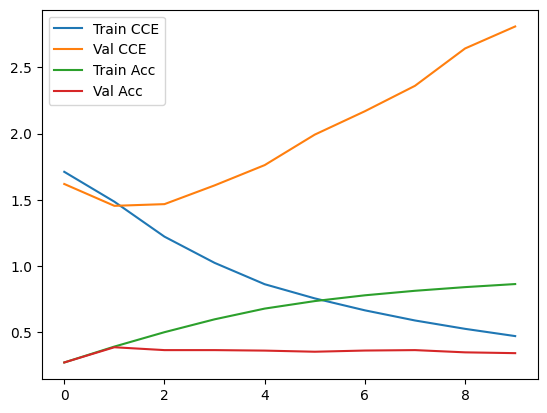

In [ ]:
plt.plot(h1b.history['loss'], label = 'Train CCE')
plt.plot(h1b.history['val_loss'], label = 'Val CCE')

plt.plot(h1b.history['acc'], label = 'Train Acc')
plt.plot(h1b.history['val_acc'], label = 'Val Acc')

plt.legend();

The model is severely overfitting, with a much higher accuracy on training data, and continuing to underperform on validation data


**Trying Dropouts and Early Stopping**

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model2.add(Bidirectional(tf.keras.layers.GRU(32)))
model2.add(Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model2.add(Dropout(rate = 0.1))
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(5, activation = 'softmax'))

model2.summary()

es = EarlyStopping(monitor = 'val_loss', patience  = 5, restore_best_weights = True)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 200, 64)           320000    
                                                                 
 bidirectional_27 (Bidirect  (None, 64)                18816     
 ional)                                                          
                                                                 
 dense_56 (Dense)            (None, 16)                1040      
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 8)                 136       
                                                                 
 dense_58 (Dense)            (None, 5)                 45        
                                                     

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
h2 = model2.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 50, epochs = 10, callbacks = es)

Epoch 1/10
128/128 [==============================] - 47s 265ms/step - loss: 1.7138 - acc: 0.2722 - val_loss: 1.6246 - val_acc: 0.2724
Epoch 2/10
128/128 [==============================] - 28s 219ms/step - loss: 1.5647 - acc: 0.3080 - val_loss: 1.5456 - val_acc: 0.2935
Epoch 3/10
128/128 [==============================] - 30s 231ms/step - loss: 1.3882 - acc: 0.3908 - val_loss: 1.4923 - val_acc: 0.3249
Epoch 4/10
128/128 [==============================] - 31s 239ms/step - loss: 1.2379 - acc: 0.4535 - val_loss: 1.5315 - val_acc: 0.3535
Epoch 5/10
128/128 [==============================] - 28s 217ms/step - loss: 1.1110 - acc: 0.5095 - val_loss: 1.5584 - val_acc: 0.3497
Epoch 6/10
128/128 [==============================] - 27s 214ms/step - loss: 1.0024 - acc: 0.5862 - val_loss: 1.6159 - val_acc: 0.3680
Epoch 7/10
128/128 [==============================] - 30s 237ms/step - loss: 0.8968 - acc: 0.6390 - val_loss: 1.7978 - val_acc: 0.3343
Epoch 8/10
128/128 [==============================] - 2

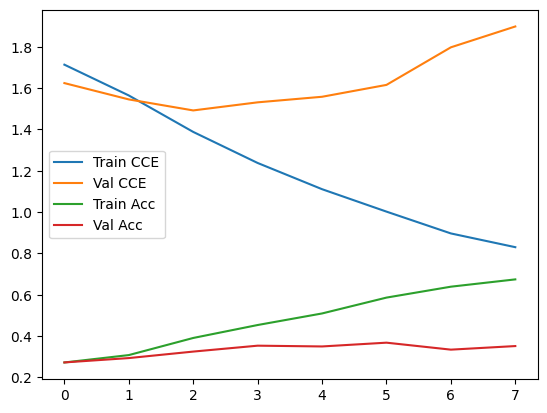

In [ ]:
plt.plot(h2.history['loss'], label = 'Train CCE')
plt.plot(h2.history['val_loss'], label = 'Val CCE')

plt.plot(h2.history['acc'], label = 'Train Acc')
plt.plot(h2.history['val_acc'], label = 'Val Acc')

plt.legend();

Model continues to generate good results on training data and poor results on testing data.

**Trying a Word2Vec layer**

In [ ]:
from gensim.models import Word2Vec

In [ ]:
X_w2v = [sentence.split() for sentence in X]

In [ ]:
w2v_model = Word2Vec(X_w2v, vector_size=500, window=5, min_count=10, workers=4)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_w2v)
vocab_size_new = len(tokenizer.word_index) + 1

In [ ]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size_new, 500))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size_new, 500, weights=[embedding_matrix], input_length=max_length, trainable=False))
model3.add(Bidirectional(tf.keras.layers.GRU(64)))
model3.add(Flatten())
model3.add(Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model3.add(Dropout(rate = 0.1))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dense(5, activation = 'softmax'))

model3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 200, 500)          7544500   
                                                                 
 bidirectional_26 (Bidirect  (None, 128)               217344    
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                528       
                                                     

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
h = model3.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 50, epochs = 3, callbacks = es)

Epoch 1/3
128/128 [==============================] - 93s 686ms/step - loss: 1.8108 - acc: 0.2695 - val_loss: 1.6508 - val_acc: 0.2625
Epoch 2/3
128/128 [==============================] - 79s 615ms/step - loss: 1.6105 - acc: 0.2701 - val_loss: 1.5847 - val_acc: 0.2550
Epoch 3/3
128/128 [==============================] - 98s 767ms/step - loss: 1.5799 - acc: 0.2714 - val_loss: 1.5735 - val_acc: 0.2738


Model has no overfitting, but doesn't perform well, with scores no better than the original y_class distribution.

None of the models perform well, but Model 2 has the highest prediction accuracy for the test data (0.3516) - with VERY significant overfitting (X_train accuracy score was 0.6744)